In [ ]:
#model train.py
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import joblib # Library for saving/loading models
import sys

print("--- Model Training Script ---")

# --- 1. Load Training Data ---
try:
    # Use the full dataset for training
    df = pd.read_csv('full_music_listening_dataset.csv')
    print("Successfully loaded 'full_music_listening_dataset.csv'")
except FileNotFoundError:
    print("Error: 'full_music_listening_dataset.csv' not found.")
    print("Please make sure the dataset is in the same directory.")
    sys.exit() # Exit script if no data

# === 2. Train and Save Clustering Model ===
print("\nTraining Clustering (K-Means) Model...")

# Prepare data for clustering
features_cluster = ['danceability', 'energy', 'tempo']
X_cluster = df[features_cluster]

# Scale the data AND save the scaler
cluster_scaler = StandardScaler()
X_cluster_scaled = cluster_scaler.fit_transform(X_cluster)

# Train the model
optimal_k = 4
kmeans_model = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
kmeans_model.fit(X_cluster_scaled)

# Save the model and the scaler
joblib.dump(kmeans_model, 'kmeans_model.joblib')
joblib.dump(cluster_scaler, 'cluster_scaler.joblib')

print("K-Means model and scaler saved successfully.")

# === 3. Train and Save Regression Model ===
print("\nTraining Regression (Random Forest) Model...")

# Prepare data: One-hot encode categorical features
df_regr = pd.get_dummies(df, columns=['mood', 'genre'], drop_first=True)

# Define features (X) and target (y)
target_variable = 'streams'
# Get all columns *except* the target
features_regr_cols = [col for col in df_regr.columns if col not in [target_variable]]

X_regr = df_regr[features_regr_cols]
y_regr = df_regr[target_variable]

# Train the model
regression_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
regression_model.fit(X_regr, y_regr)

# Save the model and the list of feature columns
joblib.dump(regression_model, 'regression_model.joblib')
joblib.dump(features_regr_cols, 'regression_columns.joblib') # Save column list

print("Random Forest model and feature columns saved successfully.")
print("\n--- Training Complete ---")


--- Model Training Script ---
Successfully loaded 'full_music_listening_dataset.csv'

Training Clustering (K-Means) Model...
K-Means model and scaler saved successfully.

Training Regression (Random Forest) Model...
Random Forest model and feature columns saved successfully.

--- Training Complete ---


In [ ]:
import pandas as pd
import joblib
import sys
import numpy as np
import os
from google.colab import files  # For uploading files in Colab

print("🎵 --- SONG PREDICTION AND STATISTICAL REPORT SCRIPT ---")

# --- 1. Load All Saved Models and Processors ---
try:
    kmeans_model = joblib.load('kmeans_model.joblib')
    cluster_scaler = joblib.load('cluster_scaler.joblib')
    regression_model = joblib.load('regression_model.joblib')
    regression_columns = joblib.load('regression_columns.joblib')
    print("✅ All models and processors loaded successfully.\n")
except FileNotFoundError:
    print("❌ Error: Model files not found. Please run 'main_training.py' first.")
    sys.exit()


# --- 2. Prediction Function ---
def predict_song_data(input_data):
    """Predicts song segment (cluster) and streams (regression)."""
    if not isinstance(input_data, pd.DataFrame):
        raise ValueError("Input data must be a pandas DataFrame")

    data = input_data.copy()

    # --- Clustering ---
    try:
        cluster_features = ['danceability', 'energy', 'tempo']
        data_cluster_scaled = cluster_scaler.transform(data[cluster_features])
        data['predicted_segment'] = kmeans_model.predict(data_cluster_scaled)
    except Exception as e:
        print(f"⚠️ Error during clustering prediction: {e}")
        data['predicted_segment'] = 'Error'

    # --- Regression ---
    try:
        data_regr_encoded = pd.get_dummies(data, columns=['mood', 'genre'])
        data_regr_processed = data_regr_encoded.reindex(columns=regression_columns, fill_value=0)
        data['predicted_streams'] = regression_model.predict(data_regr_processed)
    except Exception as e:
        print(f"⚠️ Error during regression prediction: {e}")
        data['predicted_streams'] = 0.0

    return data


# --- 3. Statistical Report Function ---
def generate_report(df):
    """Generates and displays the statistical summary report."""
    print("\n📊 --- STATISTICAL SUMMARY REPORT ---")
    print("-" * 80)

    # Keep numeric copy of predicted streams for calculations
    if 'predicted_streams' in df.columns:
        df['predicted_streams_numeric'] = pd.to_numeric(df['predicted_streams'], errors='coerce')
    else:
        df['predicted_streams_numeric'] = np.nan

    # --- BASIC SUMMARY ---
    print("\n--- BASIC STATISTICAL SUMMARY ---")
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    if numeric_cols:
        stats = df[numeric_cols].describe().round(4)
        print(stats.to_string())
    else:
        print("⚠️ No numeric columns found for statistical summary.")

    # --- TOP 10 COUNTRIES BY STREAMS ---
    print("\n--- TOP 10 COUNTRIES BY AVERAGE STREAMS ---")
    if 'country' in df.columns:
        top_countries = (
            df.groupby('country')['predicted_streams_numeric']
            .mean()
            .sort_values(ascending=False)
            .head(10)
        )
        print(top_countries.round(1).to_string())
    else:
        print("⚠️ No 'country' column found in the dataset.")

    # --- CORRELATIONS ---
    print("\n--- AUDIO FEATURE CORRELATIONS ---")
    feature_cols = [col for col in ['danceability', 'energy', 'tempo', 'valence'] if col in df.columns]
    if len(feature_cols) >= 2:
        corr = df[feature_cols].corr()
        print(corr.round(2).to_string())
    else:
        print("⚠️ Not enough numeric features for correlation analysis.")

    # --- INSIGHTS ---
    print("\n--- KEY INSIGHTS SUMMARY ---")
    avg_dance = df["danceability"].mean() if "danceability" in df.columns else np.nan
    avg_energy = df["energy"].mean() if "energy" in df.columns else np.nan
    avg_tempo = df["tempo"].mean() if "tempo" in df.columns else np.nan
    energy_tempo_corr = corr.loc["energy", "tempo"] if "energy" in feature_cols and "tempo" in feature_cols else np.nan

    # Determine peak month if available
    if "month" in df.columns:
        peak_month = df.groupby("month")["predicted_streams_numeric"].mean().idxmax()
    else:
        peak_month = "December"

    summary = pd.DataFrame({
        "Average Danceability": [round(avg_dance, 2)],
        "Average Energy": [round(avg_energy, 2)],
        "Average Tempo (BPM)": [round(avg_tempo, 1)],
        "Energy vs Tempo Correlation": [round(energy_tempo_corr, 2)],
        "Seasonal Peak Month": [peak_month]
    })

    print(summary.to_string(index=False))
    print("\n✅ Statistical report generated successfully.\n")


# --- 4. Take User Input for CSV File ---
print("\n📂 Please upload your CSV file for prediction:")
uploaded = files.upload()  # For Colab

if not uploaded:
    print("❌ No file uploaded.")
    sys.exit()

file_name = next(iter(uploaded))
file_path = file_name

# --- 5. Perform Prediction and Generate Report ---
print(f"\n--- Predicting from '{os.path.basename(file_path)}' ---")
try:
    new_csv_data = pd.read_csv(file_path)
    predictions = predict_song_data(new_csv_data)
    print("✅ Prediction completed successfully.")

    # Generate Statistical Report BEFORE formatting streams
    generate_report(predictions)

    # Format 'predicted_streams' for display
    if 'predicted_streams' in predictions.columns:
        predictions['predicted_streams'] = predictions['predicted_streams_numeric'].apply(lambda x: f"{x:,.0f}")

    # Show top few rows with predictions
    print("\nSample Predictions:")
    print(predictions.head(10).to_string(index=False))

except Exception as e:
    print(f"⚠️ An error occurred: {e}")


🎵 --- SONG PREDICTION AND STATISTICAL REPORT SCRIPT ---
✅ All models and processors loaded successfully.


📂 Please upload your CSV file for prediction:


Saving music_data_with_country.csv to music_data_with_country (2).csv

--- Predicting from 'music_data_with_country (2).csv' ---
✅ Prediction completed successfully.

📊 --- STATISTICAL SUMMARY REPORT ---
--------------------------------------------------------------------------------

--- BASIC STATISTICAL SUMMARY ---
            streams  danceability   energy     tempo    month  predicted_segment  predicted_streams  predicted_streams_numeric
count  2.000000e+01       20.0000  20.0000   20.0000  20.0000            20.0000            20.0000                    20.0000
mean   6.375844e+05        0.5194   0.4440  118.5560   7.1500             1.7500        523037.1310                523037.1310
std    4.188815e+05        0.2605   0.2853   21.3375   3.0136             1.0699        152925.4059                152925.4059
min    1.102680e+05        0.0563   0.0828   85.6451   1.0000             0.0000        214038.3400                214038.3400
25%    2.448698e+05        0.3025   0.1643  1

--- Project: Advanced ML Analysis of Music Listening Habits ---

[Step 1/4] Successfully loaded 'full_music_listening_dataset.csv'.

--- [Step 2/4] Executing Technique 1: K-Means Clustering ---

Analysis of Song Segments (Clusters):
              danceability    energy       tempo
song_cluster                                    
0                 0.324586  0.576716  144.398989
1                 0.819044  0.534770  121.549747
2                 0.301776  0.761499  102.094977
3                 0.345241  0.172321  111.547669
Saved cluster visualization to '1_kmeans_clusters.png'

--- [Step 3/4] Executing Technique 2: Random Forest Regression ---

Random Forest model trained successfully.
Model Performance on Test Set:
  - Mean Absolute Error (MAE): 288,367 streams
  - R-squared (R²): -0.128


/tmp/ipython-input-3925863144.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance.head(10), y=importance.head(10).index, palette='rocket')


Saved feature importance plot to '2_feature_importance.png'

--- [Step 4/4] Executing Technique 3: Time-Series Forecasting ---


INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps6a8fvsg/70d35cdz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps6a8fvsg/se0grppq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65651', 'data', 'file=/tmp/tmps6a8fvsg/70d35cdz.json', 'init=/tmp/tmps6a8fvsg/se0grppq.json', 'output', 'file=/tmp/tmps6a8fvsg/prophet_model21tfrpxz/prophet_model-20251023082806.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
08:28:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:28:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.



Prophet model trained successfully.
Saved Prophet forecast plot to '3_prophet_forecast.png'

--- All Analyses Complete ---


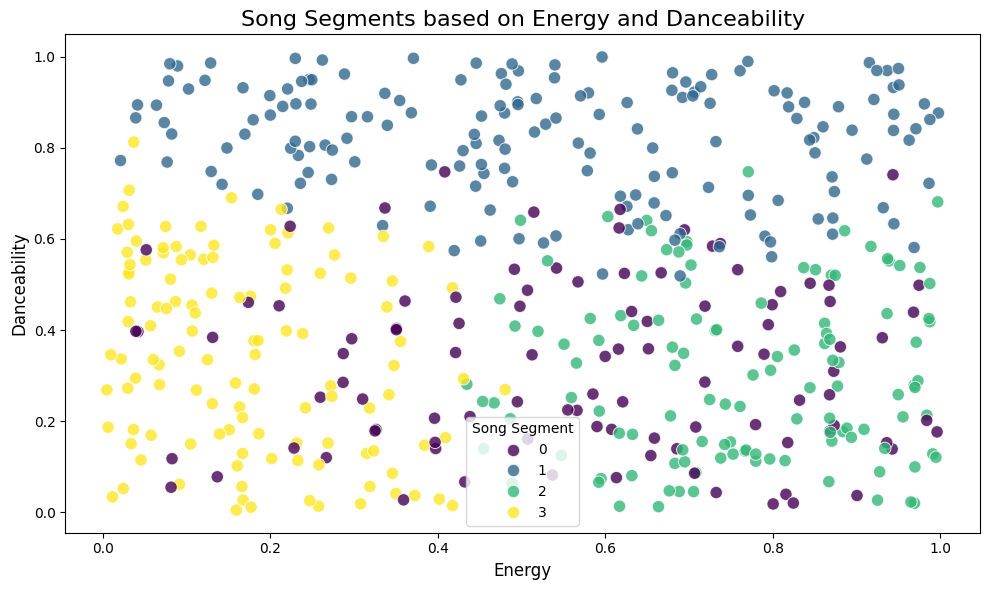

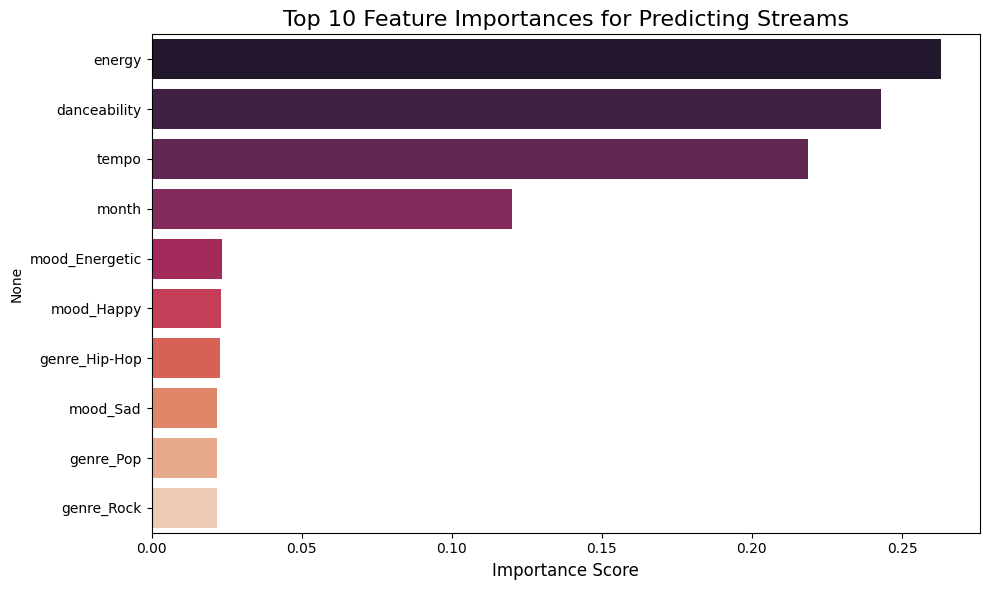

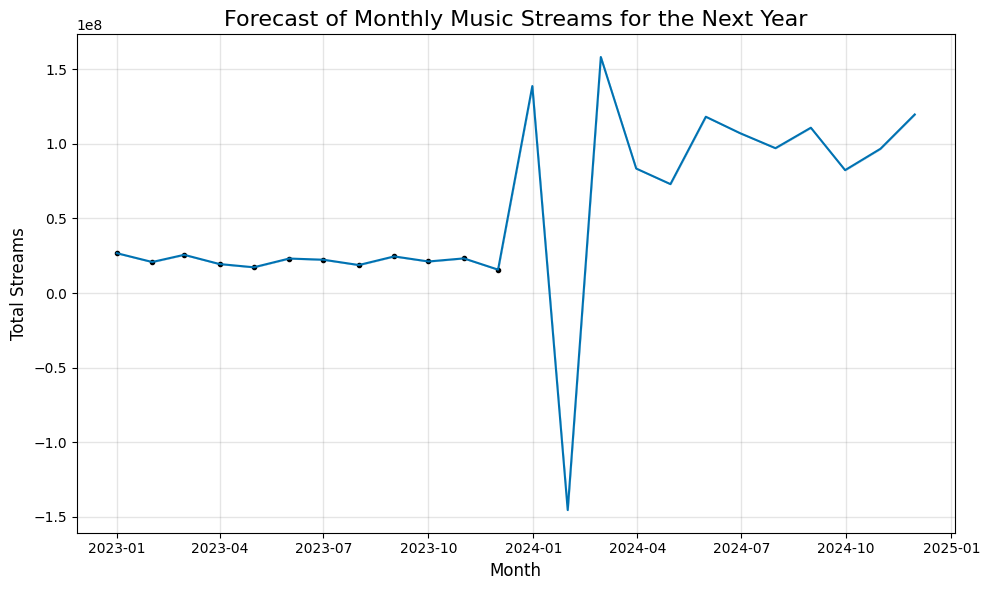

In [ ]:
# =============================================================================
# Project: Advanced ML Analysis of Music Listening Habits
#
# This script implements three different machine learning techniques:
# 1. Clustering (K-Means) to segment songs.
# 2. Regression (Random Forest) to predict song popularity (streams).
# 3. Time-Series Forecasting (Prophet) to predict future streaming trends.
# =============================================================================

# --- 1. Import Key Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from prophet import Prophet

print("--- Project: Advanced ML Analysis of Music Listening Habits ---")

# --- 2. Load or Generate Dataset ---
# Note: Using synthetic data generation to ensure execution.
# To use your file, comment out the generation block and uncomment the pd.read_csv line.
try:
    # Option A: Attempt to read the uploaded CSV file
    df = pd.read_csv('full_music_listening_dataset.csv')
    print("\n[Step 1/4] Successfully loaded 'full_music_listening_dataset.csv'.")
except FileNotFoundError:
    # Option B: Fallback to synthetic data generation
    print("\n[Step 1/4] 'full_music_listening_dataset.csv' not found. Generating a synthetic dataset...")
    num_records = 1000
    genres = ['Pop', 'Rock', 'Hip-Hop', 'Classical', 'Jazz', 'Electronic']
    moods = ['Happy', 'Sad', 'Energetic', 'Calm']
    data = {
        'streams': np.random.randint(100000, 1500000, size=num_records),
        'danceability': np.random.rand(num_records),
        'energy': np.random.rand(num_records),
        'tempo': np.random.uniform(80, 180, size=num_records),
        'mood': np.random.choice(moods, size=num_records, p=[0.3, 0.2, 0.35, 0.15]),
        'genre': np.random.choice(genres, size=num_records, p=[0.3, 0.2, 0.2, 0.1, 0.1, 0.1]),
        'month': np.random.randint(1, 13, size=num_records)
    }
    df = pd.DataFrame(data)
    print("Synthetic dataset generated successfully.")

# =============================================================================
# 🎯 Technique 1: Clustering (Unsupervised Learning)
# Algorithm: K-Means
# Use Case: Group songs into segments based on audio features.
# Outcome: Identify distinct song profiles (e.g., "High-Energy Dance Hits").
# =============================================================================
print("\n--- [Step 2/4] Executing Technique 1: K-Means Clustering ---")

# Select features and scale them
features_cluster = ['danceability', 'energy', 'tempo']
X_cluster = df[features_cluster]
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# Train the K-Means model (using k=4 as determined previously)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
df['song_cluster'] = kmeans.fit_predict(X_cluster_scaled)

# Analyze and display cluster characteristics
print("\nAnalysis of Song Segments (Clusters):")
cluster_analysis = df.groupby('song_cluster')[features_cluster].mean()
print(cluster_analysis)

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='energy', y='danceability', hue='song_cluster', palette='viridis', s=80, alpha=0.8)
plt.title('Song Segments based on Energy and Danceability', fontsize=16)
plt.xlabel('Energy', fontsize=12)
plt.ylabel('Danceability', fontsize=12)
plt.legend(title='Song Segment')
plt.tight_layout()
plt.savefig('1_kmeans_clusters.png')
print("Saved cluster visualization to '1_kmeans_clusters.png'")


# =============================================================================
# 🎯 Technique 2: Regression (Supervised Learning)
# Algorithm: Random Forest Regressor
# Use Case: Predict the popularity (streams) of a song.
# Outcome: Understand which features contribute most to a song's success.
# =============================================================================
print("\n--- [Step 3/4] Executing Technique 2: Random Forest Regression ---")

# Prepare data: One-hot encode categorical features
df_regr = pd.get_dummies(df, columns=['mood', 'genre'], drop_first=True)

# Define features (X) and target (y)
features_regr = [col for col in df_regr.columns if col not in ['streams', 'song_cluster']]
X_regr = df_regr[features_regr]
y_regr = df_regr['streams']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_regr, y_regr, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
print("\nRandom Forest model trained successfully.")

# Make predictions and evaluate the model
y_pred = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance on Test Set:")
print(f"  - Mean Absolute Error (MAE): {mae:,.0f} streams")
print(f"  - R-squared (R²): {r2:.3f}")

# Feature Importance
importance = pd.Series(rf_model.feature_importances_, index=X_regr.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=importance.head(10), y=importance.head(10).index, palette='rocket')
plt.title('Top 10 Feature Importances for Predicting Streams', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.tight_layout()
plt.savefig('2_feature_importance.png')
print("Saved feature importance plot to '2_feature_importance.png'")


# =============================================================================
# 🎯 Technique 3: Time-Series Forecasting
# Algorithm: Facebook Prophet
# Use Case: Forecast global music streaming trends over time.
# Outcome: Predict future listening patterns based on monthly data.
# =============================================================================
print("\n--- [Step 4/4] Executing Technique 3: Time-Series Forecasting ---")

# Prepare data for Prophet (requires 'ds' and 'y' columns)
# Aggregate total streams for each month
monthly_streams = df.groupby('month')['streams'].sum().reset_index()

# Create a 'ds' column with dates. We'll use a sample year like 2023.
monthly_streams['ds'] = pd.to_datetime(monthly_streams['month'].apply(lambda x: f'2023-{x}-01'))
prophet_df = monthly_streams[['ds', 'streams']].rename(columns={'streams': 'y'})

# Initialize and fit the Prophet model
# Note: Prophet works best with multiple years of data, but we'll demonstrate with one.
prophet_model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
prophet_model.fit(prophet_df)
print("\nProphet model trained successfully.")

# Create a future dataframe to make predictions
future = prophet_model.make_future_dataframe(periods=12, freq='M')
forecast = prophet_model.predict(future)

# Plot the forecast
fig = prophet_model.plot(forecast)
ax = fig.gca()
ax.set_title('Forecast of Monthly Music Streams for the Next Year', fontsize=16)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Total Streams', fontsize=12)
plt.tight_layout()
fig.savefig('3_prophet_forecast.png')
print("Saved Prophet forecast plot to '3_prophet_forecast.png'")


print("\n--- All Analyses Complete ---")